# Load ERA5 and CERRA Data from ECMWF
Unfortuently, the old mechanism to load data doesn't work anymore. This means I have to directly load the data form ECMWF. I found an article, where it is explained how to do so: https://towardsdatascience.com/read-era5-directly-into-memory-with-python-511a2740bba0 <br>

### Approach
- Differentiate between loading into memory (via xarray when working on the uni server) and loading into file system (when working locally)
- Visualize Data
- Check Dimensions within a dataset (do they vary)
- Check Dimensiona across both datasets (do they vary)

## 1. Installing the CPS API key
x Create an Copernicus account
x Get UID and API Key from Copernicus account (see below)
o create a cdsapirc file with credentials 
o do a sanity check via: more ~/.cdsapirC


UID: 187541
API Key: 620a0516-d843-40da-a991-68bf4b51447a<br><br>


**To create a cdsapirc file**<br>
Write this code snppet in terminal <br>
{<br>
  echo 'url: https://cds.climate.copernicus.eu/api/v2' <br>
  echo 'key: 187541:620a0516-d843-40da-a991-68bf4b51447a'<br>
  echo 'verify: 0'<br>
} > ~/.cdsapirc

## 2. Using CDS API
The code below shows how to request monthly mean temperatures on a specified pressure level over a range of dates. Output is stored in memory as an xarray dataset, ds. The code below also allows the output to be saved to disk, this action can be toggled on or off using the download_flag:

In [4]:
import cdsapi
import xarray as xr
import urllib3
from urllib.request import urlopen
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)


# start the client
cds = cdsapi.Client()

# dataset you want to read
dataset = "reanalysis-era5-single-levels-monthly-means"

# flag to download data
download_flag = False

# api parameters 
params = {
    "format": "netcdf",
    "product_type": "reanalysis",
    "variable": "2m_temperature",
    'month': '01',
    'year': '2021',
    'day': '01',
    'time': '00:00',
    "grid": [0.25, 0.25],
    "area": [90, -180, -90, 180], # [north, west, south, east]
    }

# retrieves the path to the file
fl = cds.retrieve(dataset, params)

# download the file 
if download_flag:
    fl.download("./output.nc")

# load into memory
with urlopen(fl.location) as f:
    ds = xr.open_dataset(f.read())

2023-11-15 18:15:57,666 INFO Welcome to the CDS
2023-11-15 18:15:57,666 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-11-15 18:15:57,811 INFO Request is queued
2023-11-15 18:16:30,261 INFO Request is completed


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


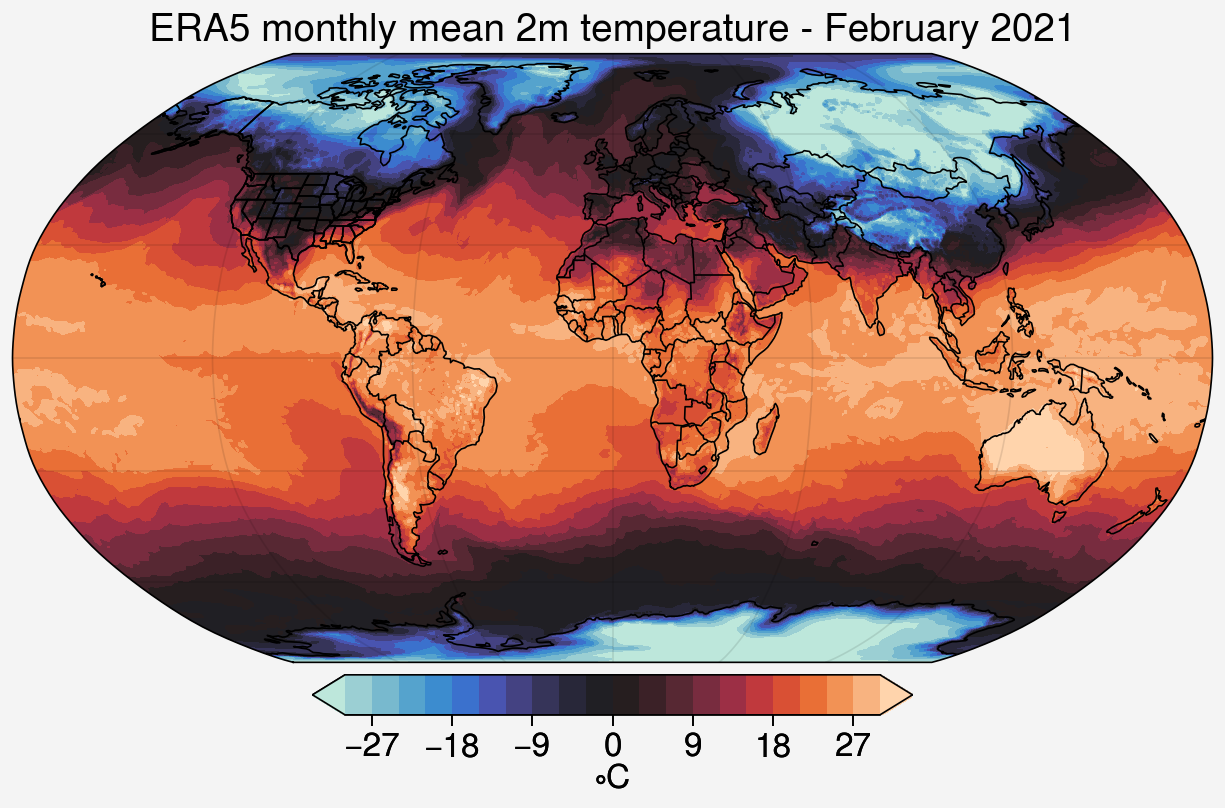

In [8]:
import proplot as plot
import numpy as np

# create figure and axes
fig, ax = plot.subplots(axwidth=6, tight=True, projection='robin', proj_kw={'lon_0': -0},)

# format options
ax.format(land=False, 
          coast=True, 
          innerborders=True, 
          borders=True,
          labels=False,
          latlines=None, lonlines=None)

# plot data
map1 = ax.contourf(ds['longitude'], ds['latitude'],ds['t2m'].squeeze()-273.15,
                   vmin=-30, vmax=30,
                   cmap='IceFire', 
                   extend='both',
                   levels=20)

# set the title
ax.set_title('ERA5 monthly mean 2m temperature - February 2021', fontsize=14)

# set the colorbar
col = ax.colorbar(map1, loc='b', shrink=0.5, values=np.arange(-30, 30))
col.set_label('$\circ$C', labelpad=0, size=12)
col.ax.tick_params(labelsize=12)